<a href="https://colab.research.google.com/github/rajesh-coventry/Foundational-Neural-Network-Perceptron-PyTorch/blob/master/03_Perceptron_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perceptron:**

### **What is a Perceptron?**

A **`perceptron`** is the simplest form of an artificial neural network and serves as the fundamental building block of deep learning.

Think of it as a mathematical model that mimics how a single neuron in the brain works.

### **How a Perceptron Works:**
1. **`Inputs`**: It receives multiple input values (like features of our data)

2. **`Weights`**: Each input has an associated `weight` that determines its importance

3. **`Weighted Sum`**: It calculates the weighted sum of all inputs

4. **`Bias`**: Adds a bias term (like an intercept in linear regression)

5. **`Activation Function`**: Applies an activation function to produce the final output

**The mathematical formula is:**

> **output = activation_function(w₁x₁ + w₂x₂ + ... + wₙxₙ + bias)**

## **Data Types in Perceptrons:**

**Perceptrons work with:**

- **`Input Data`**: Numerical features (integers, floats)

- **`Weights`**: Float values that get learned during training

- **`Bias`**: A single float value

- **`Output`**:
  - `Binary` (0 or 1) for classification
  - `Continuous` values for regression

## **Types of Problems Perceptrons Solve:**

1. **Binary Classification**: Distinguishing between two classes (`spam vs. not spam`)

2. **Linear Regression**: Predicting continuous values

3. **Linearly Separable Problems**: Problems where data can be separated by a straight line

**`Limitations`**:   
Single perceptrons `can only solve linearly separable problems` (like `AND`, `OR` logic gates) but cannot solve non-linearly separable problems (like `XOR`).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# STEP 1: CREATE A CUSTOM DATASET

def create_dataset():
    """
    Create a synthetic binary classification dataset
    This simulates a real-world scenario where we need to classify data points
    """
    print("Creating synthetic dataset...")

    # Generate a 2D dataset with 1000 samples
    # n_features=2: We'll use 2 features (x1, x2) for easy visualization
    # n_redundant=0: No redundant features
    # n_informative=2: Both features are informative
    # n_clusters_per_class=1: One cluster per class
    X, y = make_classification(
        n_samples=1000,           # Total number of data points
        n_features=2,             # Number of input features
        n_redundant=0,            # No redundant features
        n_informative=2,          # Both features contribute to classification
        n_clusters_per_class=1,   # One cluster per class
        random_state=42
    )

    print(f"Dataset created: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: Class 0: {np.sum(y==0)}, Class 1: {np.sum(y==1)}")

    return X, y

In [3]:
# STEP 2: DEFINE THE PERCEPTRON MODEL

class Perceptron(nn.Module):
    """
    Single Layer Perceptron implemented using PyTorch

    This is the simplest neural network with:
    - One linear layer (fully connected layer)
    - One activation function (sigmoid for binary classification)
    """

    def __init__(self, input_size):
        """
        Initialize the perceptron

        Args:
            input_size (int): Number of input features
        """
        super(Perceptron, self).__init__()

        # Linear layer: y = wx + b
        # input_size: number of input features
        # 1: number of output neurons (binary classification)
        self.linear = nn.Linear(input_size, 1)

        # Sigmoid activation function for binary classification
        # Sigmoid maps any real number to a value between 0 and 1
        self.sigmoid = nn.Sigmoid()

        print(f"Perceptron initialized with {input_size} input features")

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size)

        Returns:
            torch.Tensor: Output probabilities of shape (batch_size, 1)
        """
        # Step 1: Apply linear transformation (wx + b)
        linear_output = self.linear(x)

        # Step 2: Apply sigmoid activation function
        output = self.sigmoid(linear_output)

        return output

    def get_weights_and_bias(self):
        """
        Get the learned weights and bias for analysis

        Returns:
            tuple: (weights, bias)
        """
        weights = self.linear.weight.data.numpy()
        bias = self.linear.bias.data.numpy()
        return weights, bias

In [4]:
# STEP 3: DATA PREPROCESSING

def preprocess_data(X, y):
    """
    Preprocess the data for training

    Args:
        X (np.array): Input features
        y (np.array): Target labels

    Returns:
        tuple: Processed training and testing sets
    """
    print("Preprocessing data...")

    # Split the data into training and testing sets
    # 80% for training, 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Standardize the features (mean=0, std=1)
    # This helps the model converge faster and perform better
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Use same scaling as training

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Add dimension for compatibility
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

    print(f"Training set: {X_train_tensor.shape[0]} samples")
    print(f"Testing set: {X_test_tensor.shape[0]} samples")

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, scaler

In [5]:
# STEP 4: TRAINING FUNCTION

def train_perceptron(model, X_train, y_train, num_epochs=1000, learning_rate=0.01):
    """
    Train the perceptron model

    Args:
        model: The perceptron model to train
        X_train: Training input features
        y_train: Training target labels
        num_epochs: Number of training iterations
        learning_rate: Learning rate for optimization

    Returns:
        list: Training loss history
    """
    print(f"Starting training for {num_epochs} epochs with learning rate {learning_rate}")

    # Define loss function (Binary Cross Entropy for binary classification)
    # This measures how far our predictions are from the true labels
    criterion = nn.BCELoss()

    # Define optimizer (Stochastic Gradient Descent)
    # This updates the model weights to minimize the loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Store training history for analysis
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()

        # Zero the gradients (PyTorch accumulates gradients by default)
        optimizer.zero_grad()

        # Forward pass: compute predictions
        outputs = model(X_train)

        # Compute loss
        loss = criterion(outputs, y_train)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights
        optimizer.step()

        # Store loss for plotting
        train_losses.append(loss.item())

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print("Training completed!")
    return train_losses

In [6]:
# STEP 5: TESTING FUNCTION

def test_perceptron(model, X_test, y_test):
    """
    Test the trained perceptron model

    Args:
        model: Trained perceptron model
        X_test: Testing input features
        y_test: Testing target labels

    Returns:
        tuple: (predictions, probabilities, accuracy)
    """
    print("Testing the model...")

    # Set model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()

    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Get probability predictions
        test_outputs = model(X_test)

        # Convert probabilities to binary predictions
        # If probability > 0.5, predict class 1, otherwise class 0
        predicted = (test_outputs > 0.5).float()

        # Calculate accuracy
        correct = (predicted == y_test).float()
        accuracy = correct.mean()

        print(f'Test Accuracy: {accuracy.item():.4f} ({accuracy.item()*100:.2f}%)')

        return predicted.numpy(), test_outputs.numpy(), accuracy.item()

In [7]:
# STEP 6: ANALYSIS AND VISUALIZATION FUNCTIONS

def analyze_predictions(model, X_test, y_test, predicted, probabilities):
    """
    Analyze and visualize the model's predictions

    Args:
        model: Trained model
        X_test: Test features
        y_test: True test labels
        predicted: Model predictions
        probabilities: Prediction probabilities
    """
    print("\n" + "="*50)
    print("PREDICTION ANALYSIS")
    print("="*50)

    # Convert tensors to numpy for analysis
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy().flatten()
    predicted_np = predicted.flatten()
    probabilities_np = probabilities.flatten()

    # 1. Confusion Matrix Analysis
    from sklearn.metrics import confusion_matrix, classification_report

    cm = confusion_matrix(y_test_np, predicted_np)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test_np, predicted_np))

    # 2. Analyze model weights and bias
    weights, bias = model.get_weights_and_bias()
    print(f"\nLearned Weights: {weights}")
    print(f"Learned Bias: {bias}")

    # 3. Decision boundary equation
    print(f"\nDecision Boundary Equation:")
    print(f"w1*x1 + w2*x2 + bias = 0")
    print(f"{weights[0][0]:.4f}*x1 + {weights[0][1]:.4f}*x2 + {bias[0]:.4f} = 0")

    # 4. Show some example predictions
    print(f"\nSample Predictions:")
    print("Index | Feature1 | Feature2 | True Label | Predicted | Probability")
    print("-" * 65)
    for i in range(min(10, len(X_test_np))):
        print(f"{i:5d} | {X_test_np[i][0]:8.3f} | {X_test_np[i][1]:8.3f} | "
              f"{int(y_test_np[i]):10d} | {int(predicted_np[i]):9d} | {probabilities_np[i]:11.3f}")

def plot_results(train_losses, X_test, y_test, predicted, model):
    """
    Create visualizations of the training process and results

    Args:
        train_losses: Training loss history
        X_test: Test features
        y_test: True test labels
        predicted: Model predictions
        model: Trained model
    """
    plt.figure(figsize=(15, 5))

    # Plot 1: Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot 2: Data Distribution
    plt.subplot(1, 3, 2)
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy().flatten()

    # Plot true labels
    colors = ['red', 'blue']
    labels = ['Class 0', 'Class 1']
    for i in range(2):
        mask = y_test_np == i
        plt.scatter(X_test_np[mask, 0], X_test_np[mask, 1],
                   c=colors[i], label=labels[i], alpha=0.7)

    plt.title('True Data Distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)

    # Plot 3: Predictions vs True Labels
    plt.subplot(1, 3, 3)
    predicted_np = predicted.flatten()

    # Plot predictions
    for i in range(2):
        mask = predicted_np == i
        plt.scatter(X_test_np[mask, 0], X_test_np[mask, 1],
                   c=colors[i], label=f'Predicted {labels[i]}',
                   alpha=0.7, marker='x')

    plt.title('Model Predictions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

SINGLE LAYER PERCEPTRON - COMPLETE IMPLEMENTATION
Creating synthetic dataset...
Dataset created: 1000 samples, 2 features
Class distribution: Class 0: 501, Class 1: 499
Preprocessing data...
Training set: 800 samples
Testing set: 200 samples
Perceptron initialized with 2 input features

Model Architecture:
Input size: 2
Output size: 1 (binary classification)
Total parameters: 3

TRAINING PHASE
Starting training for 1000 epochs with learning rate 0.1
Epoch [100/1000], Loss: 0.3005
Epoch [200/1000], Loss: 0.2652
Epoch [300/1000], Loss: 0.2515
Epoch [400/1000], Loss: 0.2445
Epoch [500/1000], Loss: 0.2403
Epoch [600/1000], Loss: 0.2377
Epoch [700/1000], Loss: 0.2359
Epoch [800/1000], Loss: 0.2346
Epoch [900/1000], Loss: 0.2336
Epoch [1000/1000], Loss: 0.2329
Training completed!

TESTING PHASE
Testing the model...
Test Accuracy: 0.9000 (90.00%)

PREDICTION ANALYSIS
Confusion Matrix:
[[93  7]
 [13 87]]

Classification Report:
              precision    recall  f1-score   support

         0.

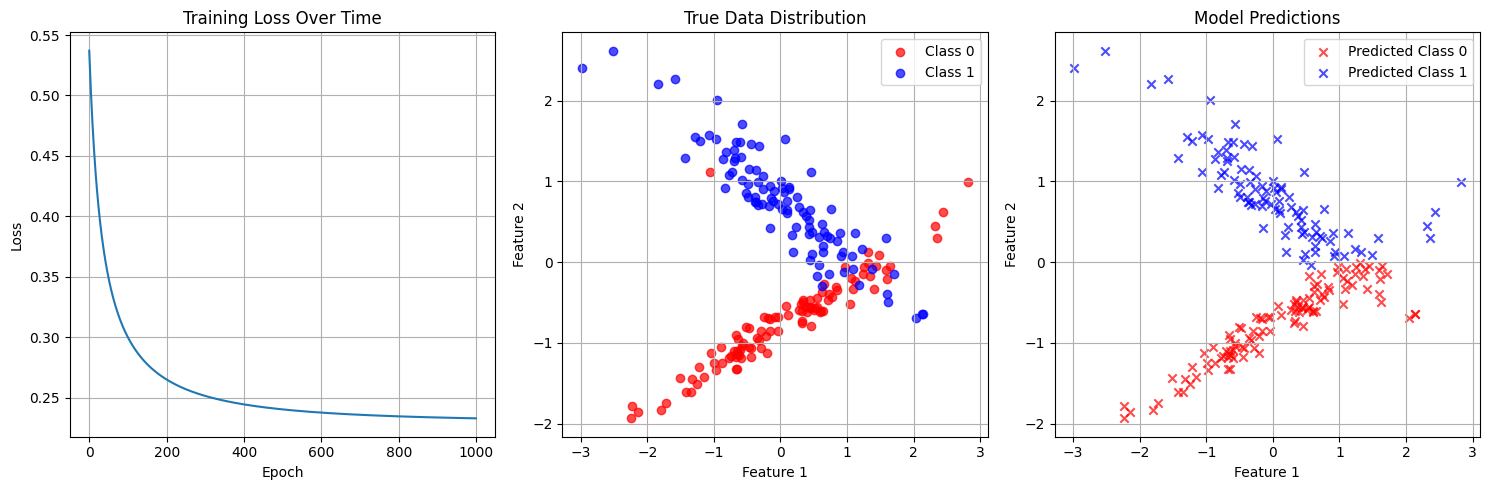


ANALYSIS COMPLETE!
Final Test Accuracy: 90.00%


In [8]:
# MAIN EXECUTION

def main():
    """
    Main function that orchestrates the entire perceptron training and testing process
    """
    print("="*60)
    print("SINGLE LAYER PERCEPTRON - COMPLETE IMPLEMENTATION")
    print("="*60)

    # Step 1: Create dataset
    X, y = create_dataset()

    # Step 2: Preprocess data
    X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)

    # Step 3: Initialize model
    input_size = X_train.shape[1]  # Number of features
    model = Perceptron(input_size)

    # Display model architecture
    print(f"\nModel Architecture:")
    print(f"Input size: {input_size}")
    print(f"Output size: 1 (binary classification)")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

    # Step 4: Train the model
    print(f"\n{'='*50}")
    print("TRAINING PHASE")
    print('='*50)
    train_losses = train_perceptron(model, X_train, y_train,
                                  num_epochs=1000, learning_rate=0.1)

    # Step 5: Test the model
    print(f"\n{'='*50}")
    print("TESTING PHASE")
    print('='*50)
    predicted, probabilities, accuracy = test_perceptron(model, X_test, y_test)

    # Step 6: Analyze results
    analyze_predictions(model, X_test, y_test, predicted, probabilities)

    # Step 7: Create visualizations
    plot_results(train_losses, X_test, y_test, predicted, model)

    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE!")
    print(f"Final Test Accuracy: {accuracy*100:.2f}%")
    print("="*60)

# Run the complete implementation
if __name__ == "__main__":
    main()

## **What The Fuck is Goin Here?**

### 1. **Perceptron Architecture:**
1. **`Input Layer`**: Receives 2 features (for our 2D dataset)

2.  **`Linear Layer`**: Performs weighted sum $(wx + b)$

3. **`Activation Function`**: Sigmoid function converts output to probability

### 2. **Training Process:**
1. **`Forward Pass`**: $Input → Linear → Sigmoid → Output$

2. **`Loss Calculation`**: `Binary Cross Entropy` measures prediction error

3. **`Backward Pass`**: Calculate `gradients` using `backpropagation`

4. **`Weight Update`**: Adjust weights using `gradient descent`

### 3. **Key Components:**
1. **`Weights`**: Learned parameters that determine feature importance

2. **`Bias`**: Learned offset term

3. **`Learning Rate`**: Controls how fast the model learns

4. **`Epochs`**: Number of complete passes through the data

### 4. **Data Preprocessing:**
1. **`Standardization`**: Scales features to have $mean=0$, $std=1$

2. **`Train/Test Split`**: Separates data for `training` and `evaluation`

3. **Tensor Conversion**: Converts NumPy arrays to `PyTorch tensors`

### 5. **Analysis Features:**
1. **`Confusion Matrix`**: Shows `correct vs incorrect predictions`

2. **`Decision Boundary`**: `Mathematical equation separating classes`

3. **`Training Loss`**: Shows `how error decreases over time`

4. **`Accuracy`**: `Percentage of correct predictions`